In [5]:
from trips.testProblems import *
from pylops import Identity, LinearOperator
from trips.utils import operator_qr, operator_svd, is_identity
from trips.parameter_selection.gcv import *
import scipy.linalg as la
import numpy as np
from trips.solvers.Hybrid_GMRES import *
# from trips.solvers.Hybrid_LSQR import *

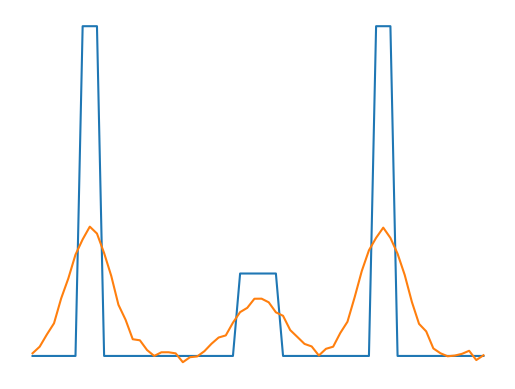

<Figure size 640x480 with 0 Axes>

In [6]:
D1D = Deblurring1D()
N = 64
n = N
A = D1D.forward_Op_matrix_1D(3, N)
# A = np.vstack((A, np.random.rand(3,N)))
x_true = D1D.gen_xtrue(N, test = 'piecewise')
b_true = A@x_true
(b, delta) = D1D.add_noise(b_true, 'Gaussian', 0.05)
plt.plot(x_true)
D1D.plot_data(b)
L = np.eye(A.shape[1])
deltanew = la.norm(b - b_true)

In [24]:
import numpy as np 
from scipy.optimize import newton, minimize
import scipy.optimize as op
import scipy.linalg as la

from trips.utils import operator_qr, operator_svd, is_identity
# from .gcv import gcv_numerator
import warnings

def discrepancy_principle(A, b, L, delta = None, eta = 1.01, **kwargs):

    if not ( isinstance(delta, float) or isinstance(delta, int)):

        # raise TypeError('You must provide a value for the noise level delta.')
        raise Warning("""A value for the noise level delta was not provided. A default value of 0.01 has been used. 
                    Please supply a value of delta based on the estimated noise level of the problem.""")

        delta = 0.01
    valid = False ## Just to be able to call the new DP that Silvia coded
    if is_identity(L) and valid == True:
        U, S, V = la.svd(A, full_matrices=False)
        singular_values = S**2
        singular_values.shape = (singular_values.shape[0], 1)
        bhat = U.T @ b
        # beta = 1.0
        beta = 1e8

        alpha = 0.01

        iterations = 0

        while (iterations < 30) or ((iterations <= 100) and (np.abs(alpha) < 10**(-16))):

            f = ((singular_values*beta + 1)**(-2)).T @ bhat - (eta*delta)**2

            f_prime = -2*  ((singular_values*beta + 1)**(-3) * singular_values).T @ bhat

            beta_new = beta - f/f_prime


            if abs(beta_new - beta) < 10**(-7)* beta:
                break

            beta = beta_new

            alpha = 1/beta_new

            iterations += 1
    else:
        tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
        discr_func_zero = lambda reg_param: np.linalg.norm(np.matmul(A,tikh_sol(reg_param)).reshape((-1,1)) - b.reshape((-1,1))) - (eta*delta)
        alpha = op.fsolve(discr_func_zero, 1e2)[0]

    return alpha#{'x':alpha}

In [17]:
from trips.decompositions import golub_kahan_update
import numpy as np
from scipy import linalg as la
from trips.parameter_selection.gcv import *
# from trips.parameter_selection.discrepancy_principle import *
from pylops import Identity
from trips.solvers import Tikhonov

def hybrid_lsqr(A, b, n_iter, regparam = 'gcv', **kwargs): # what's the naming convention here?

    delta = kwargs['delta'] if ('delta' in kwargs) else None

    eta = kwargs['eta'] if ('eta' in kwargs) else 1.01

    if regparam == 'dp' and delta == None:
        raise Exception("""A value for the noise level delta was not provided and the discrepancy principle cannot be applied. 
                    Please supply a value of delta based on the estimated noise level of the problem, or choose the regularization parameter according to gcv.""")
    
    n = A.shape[1]
    beta = np.linalg.norm(b)
    U = b.reshape((-1,1))/beta
    B = np.empty(1)
    V = np.empty((n,1))
    RegParam = np.zeros(n_iter,)

    for ii in range(n_iter):
        # print(ii)
        (U, B, V) = golub_kahan_update(A, U, B, V)
        bhat = np.zeros(ii+2,); bhat[0] = beta ###
        L = Identity(B.shape[1], B.shape[1])
        y = la.lstsq(B,bhat)[0]
        nrmr = np.linalg.norm(bhat - B@y)
        if ii == 0:
            lambdah = 0
        else:
            if regparam == 'gcv':
                #lambdah = generalized_crossvalidation(B, bhat, L, **kwargs)['x'].item()
                lambdah = generalized_crossvalidation(B, bhat, L, **kwargs)
            elif regparam == 'dp':
                print(ii)
                print(eta)
                print(delta)
                print(nrmr)
                if nrmr <= eta*delta:
                    lambdah = discrepancy_principle(B, bhat, L, **kwargs)['x'].item()
                    # lambdah = 0
                else:
                    lambdah = 0
            else:
                lambdah = regparam
            RegParam[ii] = lambdah
            L = L.todense() if isinstance(L, LinearOperator) else L
            y = la.lstsq(np.matmul(B.T,B) + lambdah*np.matmul(L.T,L), np.matmul(B.T,bhat))[0] ## SG: potentially needs L.T*L; also why lstsq? May just need a solver for linear system; also: you may need np.matmul; also: these are not the normal eqs (you need B'*b)
            #y = Tikhonov(B, bhat, L, regparam = lambdah)[0]
            x = V @ y
    return x, U, B, V, RegParam

In [25]:
out_hybridlsqr = hybrid_lsqr(A, b, 20, regparam = 'dp', delta = deltanew)

1
1.01
0.06737815009758147
0.2733765532704711
2
1.01
0.06737815009758147
0.19217070019412416
3
1.01
0.06737815009758147
0.12763917917705797
4
1.01
0.06737815009758147
0.11173740172978211
5
1.01
0.06737815009758147
0.10465595376006004
6
1.01
0.06737815009758147
0.08995813707759044
7
1.01
0.06737815009758147
0.08345795547896631
8
1.01
0.06737815009758147
0.07992885801713105
9
1.01
0.06737815009758147
0.0759334247676454
10
1.01
0.06737815009758147
0.06909773011880954
11
1.01
0.06737815009758147
0.06603992354411957


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 1

In [16]:
regP = out_hybridlsqr[4]
print(regP)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
U = out_hybridlsqr[1]; B = out_hybridlsqr[2]; V = out_hybridlsqr[3]

In [12]:
bhat = np.zeros(14,); bhat[0] = np.linalg.norm(b)
L = np.eye(13)

In [13]:
lambdah = discrepancy_principle(B, bhat, L, delta = deltanew)

/Users/silvia/opt/anaconda3/envs/trip/lib/python3.8/site-packages/trips/parameter_selection/discrepancy_principle.py:84: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((L.shape[0],1)))))[0]
/Users/silvia/opt/anaconda3/envs/trip/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [14]:
print(lambdah)

2.5551000000000003e-06


In [ ]:
regP = out_hybridlsqr[4]
print(regP)